Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


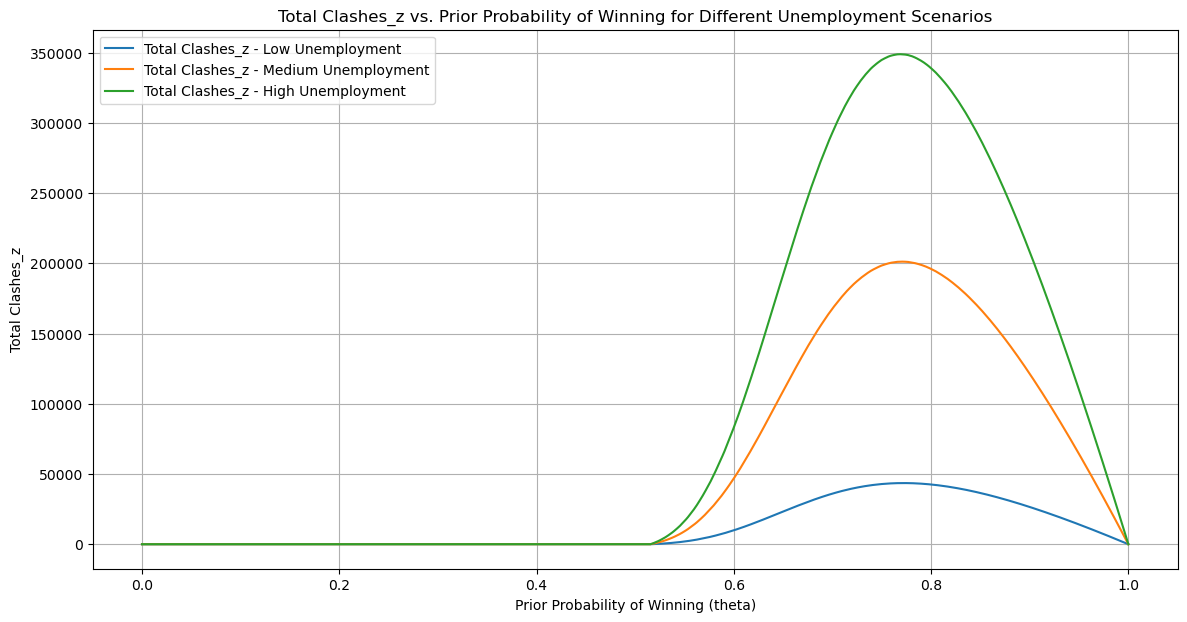

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

## Endogenous variables:

# pi  proba that a claim is revived by a claimant;
# rev   count of revived claims for claimant type i and debtor type j;   
# xd   (expected) income of debtor;
# xc  income of claimant;

## Exogenous variables:

# N   target population size (bottom worker income quintile?);
# xdempl   income of debtor when employed;
# xduir   regular (basic) income of debtor when unemployed;
# xcempl  income of claimant when employed;
# xcuir  regular (basic) income of claimant when unemployed;
# sdc  share of outstanding dormant claims (interpersonal loans) in population N (equivalently, share of debtor);

# suic  unemployment rates among claimants;
# suid  unemployment rates among debtors;
# theta  share of unemployed covered by the $600 FPUC;
# prjt joint proba of employment and income states (accounting for FPUC coverage);


## Parameters and coefficients:

# a   pi proba function parameter (factor);
# σ   pi proba function parameter (exponent);

## state variables:

# i is claimant state (state includes both employment and income situations)
# j is debtor state
# prc and prd are probabilities associated with a particular state

# Parameters for the model
SC = 300  # Cost of skirmish for Claimant
SD = 300  # Cost of skirmish for Debtor
CC = 5000  # Cost of clash for Claimant
lower, upper = 0, 5000
mu, sigma = 2500, 1000 # Mean and standard deviation
N_b = 1000000 # Number of samples
B_values = truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(N_b)

def calculate_clash_probability(B, SC, SD, CC, theta):
    theta_bar = CC / (B - SC + CC) if B > SC else 1
#    Psi_values = np.where(theta >= theta_bar, (1 - theta + 0.01) * (B / (B + SD)), 0.01)
    Psi_values = np.where(theta >= theta_bar, (1 - theta) * (B / (B + SD)), 0)
    return Psi_values

theta_values = np.linspace(0, 1, 1000)
aggregate_Psi = np.zeros_like(theta_values)
for B in B_values: 
    Psi_values = calculate_clash_probability(B, SC, SD, CC, theta_values)
    aggregate_Psi += Psi_values
aggregate_Psi /= N_b

# Bottom and second quintile of the income distribution unemployment level Unemployment for the bottom and second quintile of the income distribution
unemployment_scenarios = {
   'low': (0.026, 0.015),
    'medium': (0.1125, 0.0715),
    'high': (0.199, 0.128)
}

#unemployment_scenarios = {
 #   'low': (0.02, 0.05),
  #  'medium': (0.05, 0.10),
   # 'high': (0.07, 0.15)
#}

a, sigma = 1, 3
# Claimant unemployed, debtor unemployed, income of claimant when employed, income of debtor when employed)  
xcuir, xduir, xcempl, xdempl = 372, 186, 592, 296
#xcuir, xduir, xcempl, xdempl = 300, 150, 1000, 300 
sdc, N = 0.2, 163 * 10**6

scenario_results = {scenario: {'total_revived_claims': [], 'total_clashes_z': []} for scenario in unemployment_scenarios}

def calculate_totals_for_theta(theta, suic, suid, aggregate_Psi_theta):
    total_revived_claims = 0
    total_clashes_z = 0
    for i in range(1, 4):
        if i == 1:
            xc, prc = xcempl, 1 - suic
        elif i == 2:
            xc, prc = xcuir, suic * (1 - theta)
        else:
            xc, prc = xcuir + 600, suic * theta
        for j in range(1, 3):
            if j == 1:
                xd, prd = xdempl, 1 - suid
            else:
                xd, prd = (xduir * (1 - theta)) + ((xduir + 600) * theta), suid
            prjt = prc * prd
            pi = (a * xd)**sigma / ((a * xd)**sigma + xc**sigma)
            rev = N * sdc * prjt * pi
            total_revived_claims += rev
            clash_prob = 0 if j == 1 else aggregate_Psi_theta
            total_clashes_z += rev * clash_prob
    return total_revived_claims, total_clashes_z

for index, theta in enumerate(theta_values):
    aggregate_Psi_theta = aggregate_Psi[index]
    for scenario, (suic, suid) in unemployment_scenarios.items():
        total_revived_claims, total_clashes_z = calculate_totals_for_theta(theta, suic, suid, aggregate_Psi_theta)
        scenario_results[scenario]['total_revived_claims'].append(total_revived_claims)
        scenario_results[scenario]['total_clashes_z'].append(total_clashes_z)

# Plotting the results
plt.figure(figsize=(14, 7))
for scenario, data in scenario_results.items():
    plt.plot(theta_values, data['total_clashes_z'], label=f"Total Clashes_z - {scenario.capitalize()} Unemployment")
plt.xlabel('Prior Probability of Winning (theta)')
plt.ylabel('Total Clashes_z')
plt.title('Total Clashes_z vs. Prior Probability of Winning for Different Unemployment Scenarios')
plt.legend()
plt.grid(True)
plt.show()


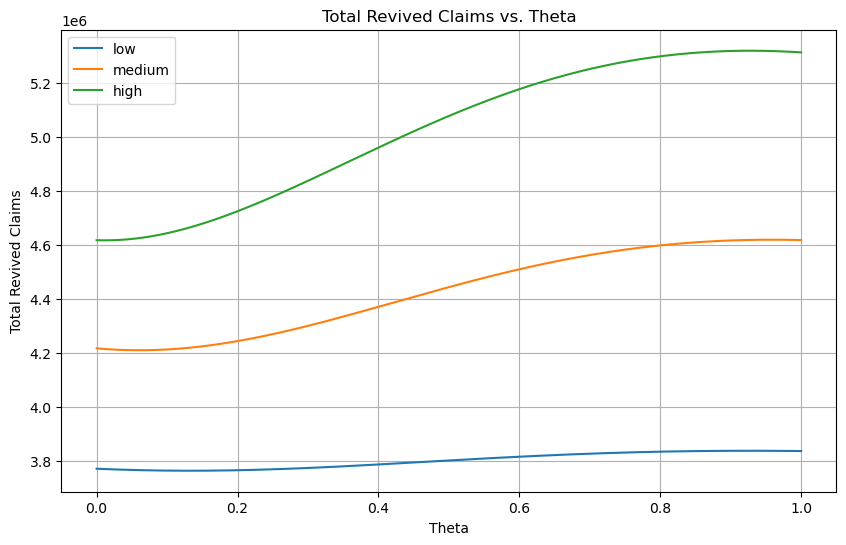

In [2]:
# Plotting Total Revived Claims vs. Theta
plt.figure(figsize=(10, 6))
for scenario, data in scenario_results.items():
    # Extracting 'total_revived_claims' for each scenario
    total_revived_claims = data['total_revived_claims']
    plt.plot(theta_values, total_revived_claims, label=scenario)

plt.title('Total Revived Claims vs. Theta')
plt.xlabel('Theta')
plt.ylabel('Total Revived Claims')
plt.legend()
plt.grid(True)
plt.show()


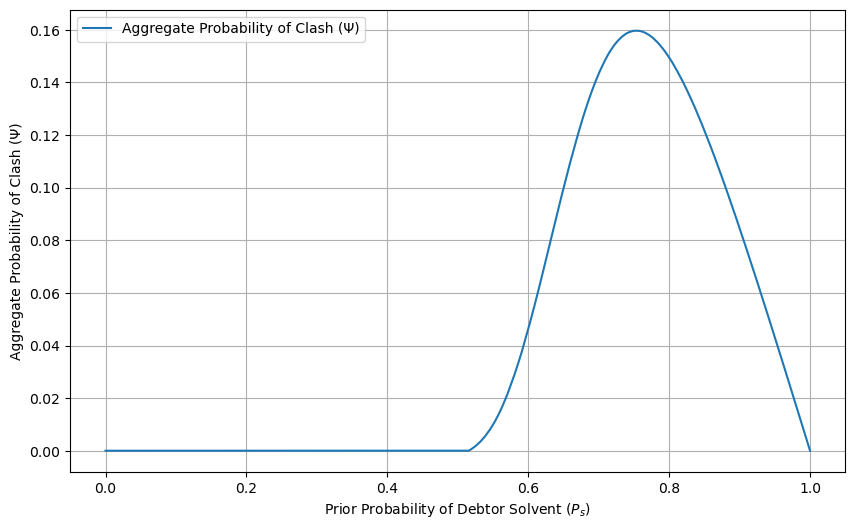

In [3]:
# Re-plotting the aggregate probability of clash versus theta
plt.figure(figsize=(10, 6))
plt.plot(theta_values, aggregate_Psi, label='Aggregate Probability of Clash (Ψ)')
plt.xlabel('Prior Probability of Debtor Solvent ($P_s$)')
plt.ylabel('Aggregate Probability of Clash (Ψ)')
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('aggregate_clash_probability_truncnormal.pdf')

plt.show()


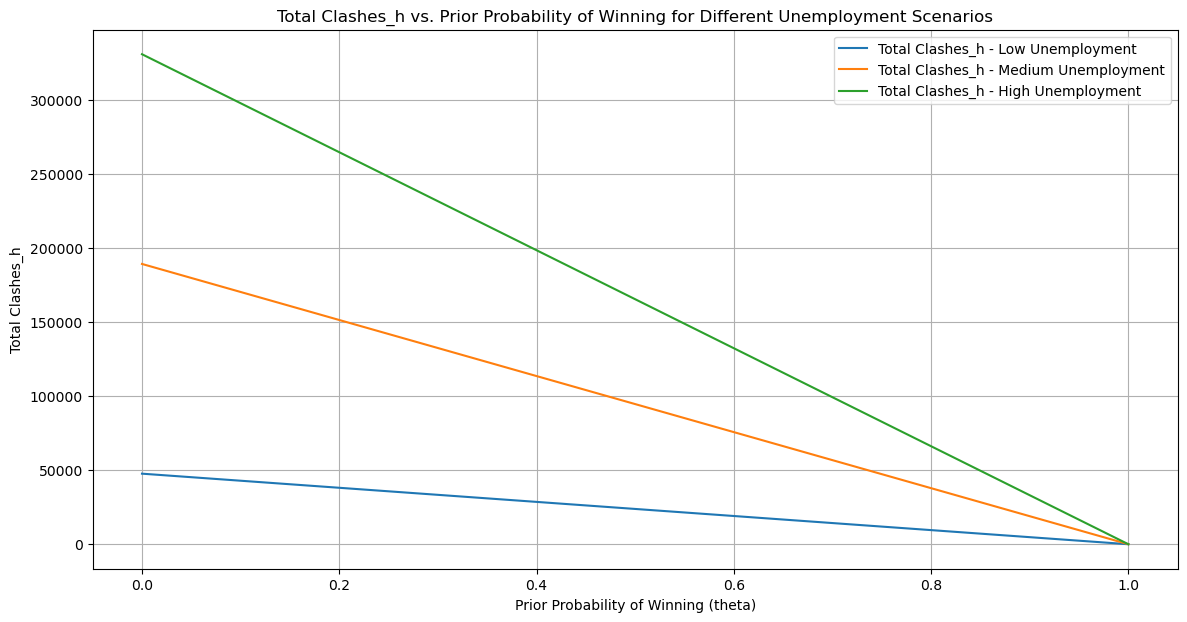

In [4]:
# Unemployment scenarios for the entire distribution
# Including the updated unemployment rates for quintiles 1 and 2, and adding rates for quintiles 3 to 5
unemployment_scenarios = {
    'low': {'q1': 0.026, 'q2': 0.015, 'q3': 0.015, 'q4': 0.009, 'q5': 0.008},
    'medium': {'q1': 0.1125, 'q2': 0.0715, 'q3': 0.0475, 'q4': 0.0355, 'q5': 0.023},
    'high': {'q1': 0.199, 'q2': 0.128, 'q3': 0.08, 'q4': 0.062, 'q5': 0.038}
}

# Parameters for the "home effect" equation
n = N / 5  # Number of workers in each quintile
a = 0.02
b = 0.02

# Function to calculate the number of unemployed people (X) across all quintiles
def calculate_X(scenario_rates):
    X = sum(scenario_rates[quintile] * n for quintile in scenario_rates)
    return X

# Function to calculate the number of clashes based on the home effect
def calculate_clashes_h(X, theta, a, b):
    return a * X - b * theta * X
#    return a * X - b * (theta ** 2) * X

# Calculating clashes and plotting
plt.figure(figsize=(14, 7))
for scenario, rates in unemployment_scenarios.items():
    X = calculate_X(rates)
    clashes_h = [calculate_clashes_h(X, theta, a, b) for theta in theta_values]
    plt.plot(theta_values, clashes_h, label=f"Total Clashes_h - {scenario.capitalize()} Unemployment")

plt.xlabel('Prior Probability of Winning (theta)')
plt.ylabel('Total Clashes_h')
plt.title('Total Clashes_h vs. Prior Probability of Winning for Different Unemployment Scenarios')
plt.legend()
plt.grid(True)
plt.show()


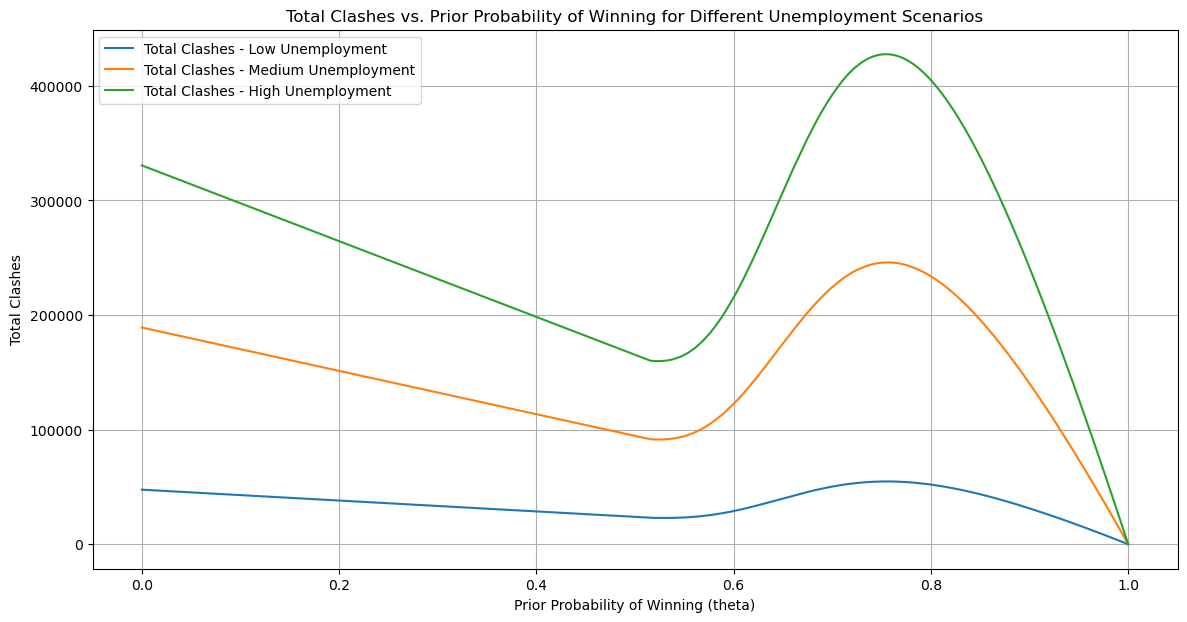

In [5]:
# Initialize a dictionary to store total clashes (zombie + home effect)
total_scenario_results = {scenario: {'total_clashes': []} for scenario in unemployment_scenarios}

# Calculate total clashes for each scenario and theta
for scenario, rates in unemployment_scenarios.items():
    X = calculate_X(rates)  # Calculate the number of unemployed people for the scenario
    clashes_h = np.array([calculate_clashes_h(X, theta, a, b) for theta in theta_values])
    clashes_z = np.array(scenario_results[scenario]['total_clashes_z'])  # Clashes from zombie model
    total_clashes = clashes_z + clashes_h  # Add clashes from both models
    total_scenario_results[scenario]['total_clashes'] = total_clashes

# Plotting the total clashes
plt.figure(figsize=(14, 7))
for scenario, data in total_scenario_results.items():
    plt.plot(theta_values, data['total_clashes'], label=f"Total Clashes - {scenario.capitalize()} Unemployment")

plt.xlabel('Prior Probability of Winning (theta)')
plt.ylabel('Total Clashes')
plt.title('Total Clashes vs. Prior Probability of Winning for Different Unemployment Scenarios')
plt.legend()
plt.grid(True)
plt.show()

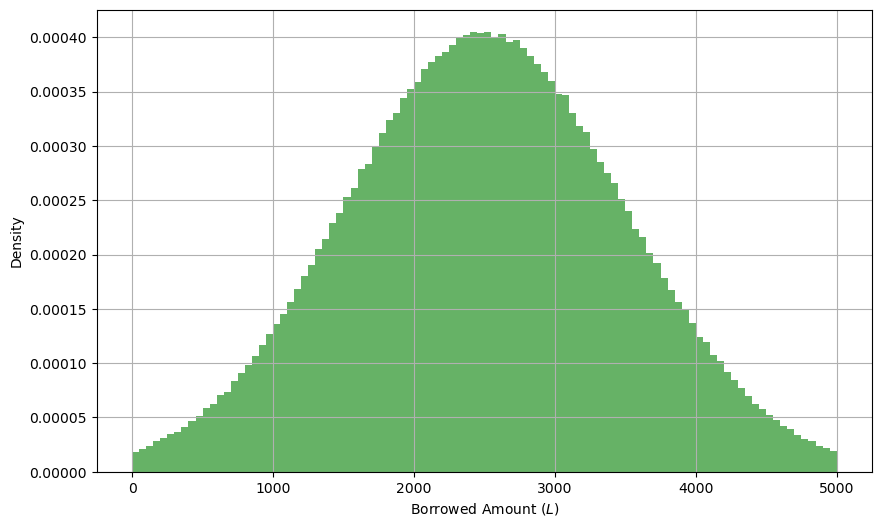

In [6]:
# Plotting the truncated normal distribution
plt.figure(figsize=(10, 6))
plt.hist(B_values, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Borrowed Amount ($L$)')
plt.ylabel('Density')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('truncated_normal_distribution.pdf')

plt.show()

In [7]:
# Calculate the average loan amount
average_B = np.mean(B_values)
print(f"The average loan amount is: {average_B:.2f}")

The average loan amount is: 2500.94


In [8]:
max_aggregate_Psi = np.max(aggregate_Psi)
print(f"The maximum aggregate probability of a clash is: {max_aggregate_Psi:.4f}")

The maximum aggregate probability of a clash is: 0.1597


In [9]:
theta_bar_values = [CC / (B - SC + CC) if B > SC else 1 for B in B_values]
average_theta_bar = np.mean(theta_bar_values)
print(f"The average P_S low bar (theta_bar) is: {average_theta_bar:.4f}")


The average P_S low bar (theta_bar) is: 0.7069


In [10]:
# Assuming aggregate_Psi and theta_values have been calculated already
max_index = np.argmax(aggregate_Psi)  # Find the index of the maximum value in aggregate_Psi
max_Ps = theta_values[max_index]  # Get the corresponding value of P_s

print(f"The maximum aggregate probability is reached at P_s = {max_Ps:.3f}")


The maximum aggregate probability is reached at P_s = 0.755


In [11]:
# Finding the aggregate probability of a clash for P_s = 0.6
P_s = 0.6
index = np.searchsorted(theta_values, P_s)
aggregate_clash_probability_at_P_s = aggregate_Psi[index]

print(f"The aggregate probability of a clash given P_s = {P_s} is {aggregate_clash_probability_at_P_s:.6f}")


The aggregate probability of a clash given P_s = 0.6 is 0.046833


In [12]:
# Given values
aggregate_clash_probability_at_P_s = 0.046598
total_loans = 1000000

# Calculate the number of clashes
number_of_clashes = aggregate_clash_probability_at_P_s * total_loans

print(f"The number of clashes given P_s = 0.6 and 1 million loans is {number_of_clashes:.0f}")


The number of clashes given P_s = 0.6 and 1 million loans is 46598


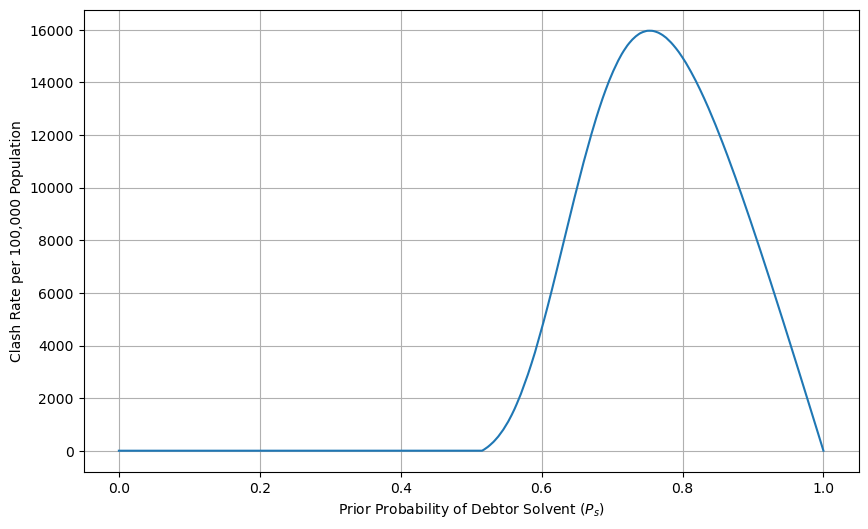

In [16]:
# Calculate the clash rate per 100,000 population
clash_rate_per_100k = aggregate_Psi * 100000

# Plotting the clash rate per 100,000 population versus theta
plt.figure(figsize=(10, 6))
plt.plot(theta_values, clash_rate_per_100k, label='Clash Rate per 100,000 Population')
plt.xlabel('Prior Probability of Debtor Solvent ($P_s$)')
plt.ylabel('Clash Rate per 100,000 Population')
#plt.legend()
plt.grid(True)

# Save the plot as a PDF file
plt.savefig('clash_rate_per_100k_population.pdf')

plt.show()